In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import pandas as pd

# Plot analytical double-well model

## Analytical form

$U(x, y) = B_0 (x^2 - x_0)^2 + K (y - y_0)^2$

In [2]:
def dw_u(s, s0=1.0, B0=2.0):
    ds = s**2 - s0
    u = B0 * ds**2
    return u
            
def para_u(s, s0=0.0, K=100.):
    ds = s - s0
    u = K * ds**2
    return u

def u_2d(x, y):
    ux, uy = dw_u(x), para_u(y)
    return ux + uy

In [3]:
analytic_x2d = np.linspace(-1.5, 1.5, 100)
analytic_y2d = np.linspace(-1.5, 1.5, 100)

analytic_x2d, analytic_y2d = np.meshgrid(analytic_x2d, analytic_y2d)
a_mids_x, a_mids_y, a_fe2d = analytic_x2d, analytic_y2d, u_2d(analytic_x2d, analytic_y2d)

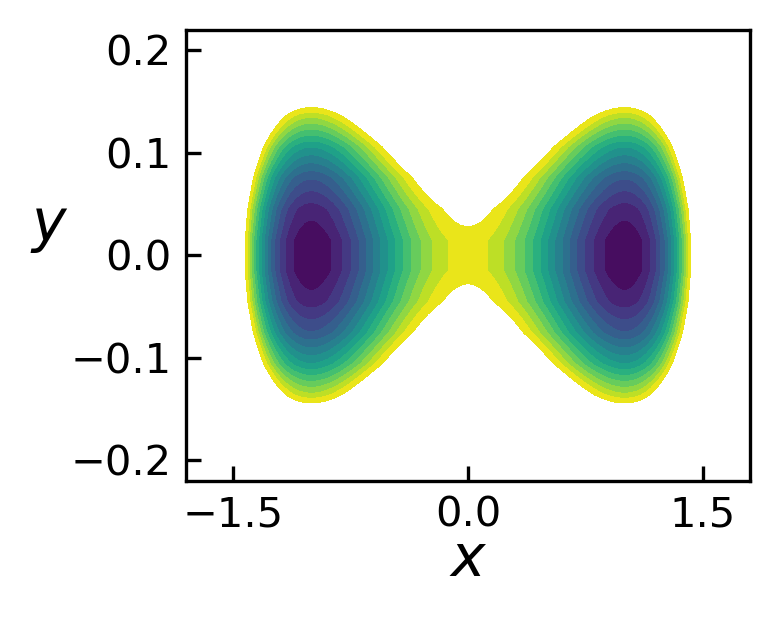

In [4]:
levels = np.linspace(0, 2.1, 16)

fig, ax = plt.subplots(figsize=(2.7, 2.16), dpi=300)
ctrp = ax.contourf(a_mids_x, a_mids_y, a_fe2d, levels=levels)

ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel(r'$x$', size=14, labelpad=-1)
ax.set_ylabel(r'$y$', size=14, rotation=0, labelpad=5)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-0.22, 0.22)

ax.set_xticks(np.linspace(-1.5, 1.5, 3))

plt.tight_layout()
plt.show()

# Analyze unbiased simulation data

In [5]:
t_arr = []
p_arr = []
unbiased_sim_traj = gsd.hoomd.open('./data/unbiased/unbiased_sim_traj.gsd')
for frame in unbiased_sim_traj:
    t_arr.append(frame.configuration.step)
    p_arr.append(frame.particles.position[0])

t_arr = np.asarray(t_arr)
p_arr = np.asarray(p_arr)
px_arr, py_arr, pz_arr = p_arr.T

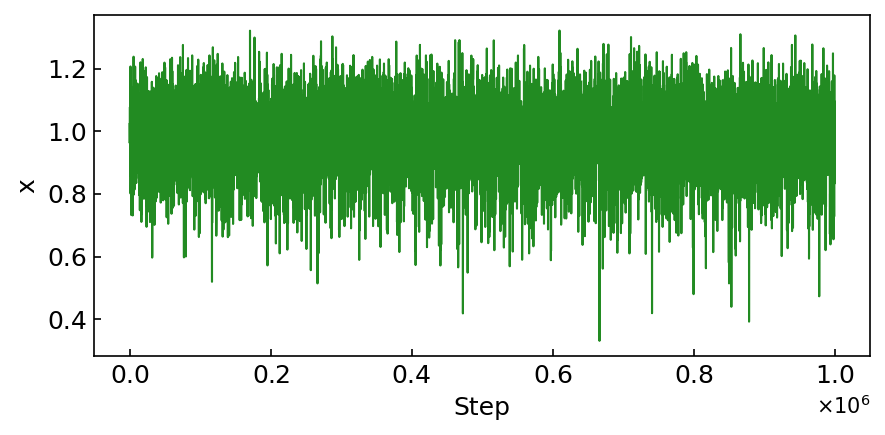

In [6]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.plot(t_arr, px_arr, linewidth=1, color='ForestGreen')
ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
ax.set_xlabel('Step', size=12)
ax.set_ylabel('x', size=12)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))
ax.xaxis.major.formatter._useMathText = True
plt.tight_layout()
plt.show()

# Analyze hMCMetaD simulation data

In [7]:
data_fn = './data/biased/WTMetaD_log.txt'
metad_data = pd.read_csv(data_fn, sep='\s+')
timestep = metad_data['t']
acceptance = metad_data['acceptance']
cv = metad_data['cv']
bias_pot = metad_data['bias_pot']
ebetac = metad_data['ebetac']

### Plot acceptance vs time

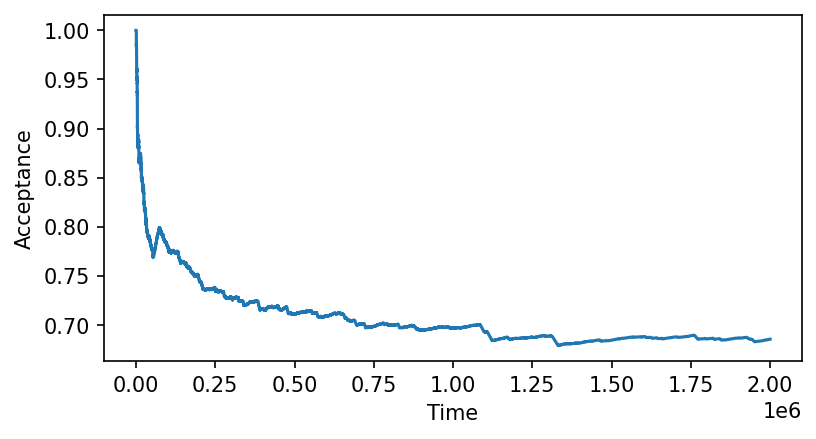

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
ax.plot(timestep, acceptance)
ax.set_xlabel('Time')
ax.set_ylabel('Acceptance')
plt.show()

### Plot CV and bias potential vs time

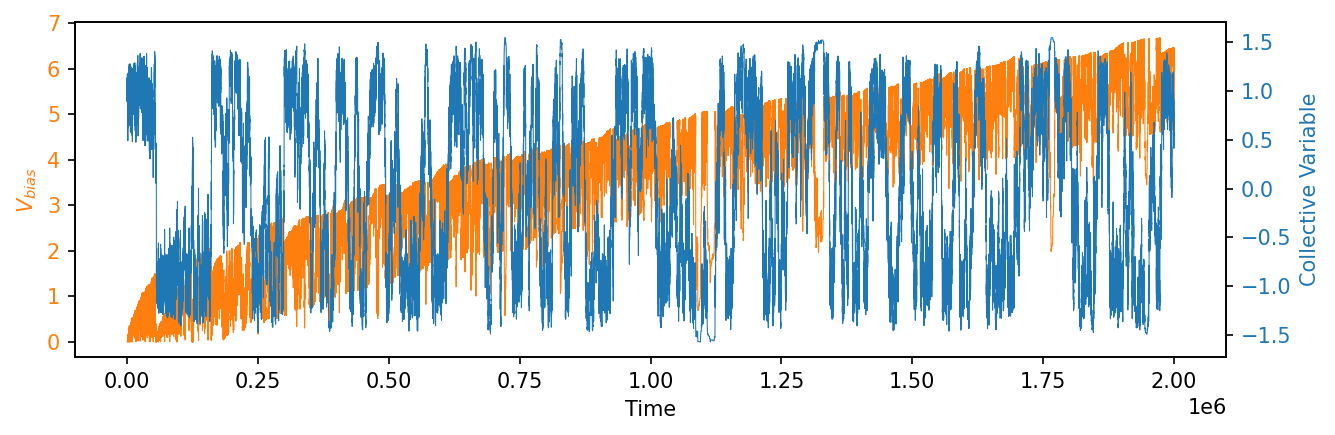

In [9]:
fig, ax2 = plt.subplots(figsize=(9, 3), dpi=150)
ax = ax2.twinx()
ax.plot(timestep, cv, linewidth=0.5, color='C0')
ax.set_ylabel("Collective Variable", color='C0')
ax.tick_params(axis='y', labelcolor='C0')

ax2.plot(timestep, bias_pot, linewidth=0.5, color='C1')
ax2.set_ylabel("$V_{bias}$", color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_xlabel("Time")

plt.tight_layout()
plt.show()

### Calculate free energy profile

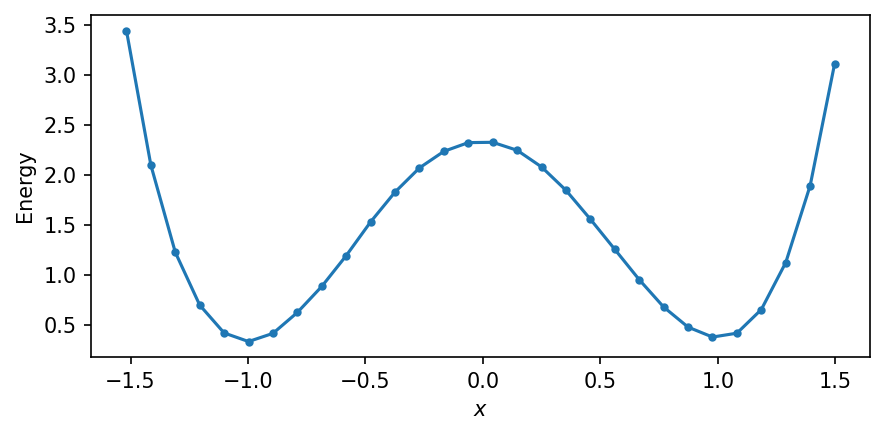

In [10]:
kT = 0.2
weights = np.exp(bias_pot/kT) / ebetac
number_bins = 30
hist, bin_edges = np.histogram(cv, bins=number_bins,
                               density=False, weights=weights)
prob = hist/sum(hist)
mids = 0.5*(bin_edges[1:]+bin_edges[:-1])

freeE = -kT * np.log(prob)
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
ax.plot(mids, freeE, marker='.')

ax.set_xlabel(r"$x$")
ax.set_ylabel("Energy")
plt.tight_layout()
plt.show()